In [1]:
# install dependencies
# !pip install casadi

# Obstacle avoidance with TurtleBot



In [2]:
import numpy as np
from math import *

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from copy import deepcopy, copy

### Defining the obstacles, the initial point and the goal point

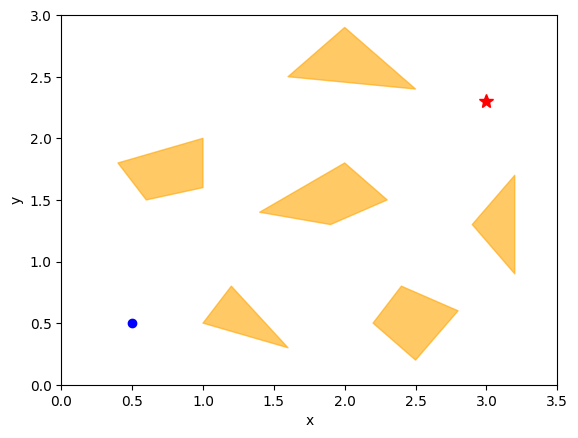

In [3]:
# Initial state of the robot
x0 = [0.5, 0.5, 0.]
# x0 = [3., 0., 0.]

# Goal state
x_ref = [3., 2.3, 0.]
# x_ref = [2.0, 2.0, 0]

# For collision checking we will overapproximate the robot with a circle of radius r
r_robot = 0.15

# Define obstacles in the environment (Each obstacle is defined by a list of its vertex positions)
obstacles = []
obstacles.append([[1., 0.5], [1.2, 0.8], [1.6, 0.3]])
obstacles.append([[0.6, 1.5], [0.4, 1.8], [1., 2.], [1., 1.6]])
obstacles.append([[1.4, 1.4], [2., 1.8], [2.3, 1.5], [1.9, 1.3]])
obstacles.append([[2.9, 1.3], [3.2, 1.7], [3.2, 0.9]])
obstacles.append([[2.5, 0.2], [2.2, 0.5], [2.4, 0.8], [2.8, 0.6]])
obstacles.append([[1.6, 2.5], [2., 2.9], [2.5, 2.4]])

# Plot environment
fig,ax = plt.subplots()

patches = []
for obs in obstacles:
    p = Polygon(obs)
    patches.append(p)


p_col = PatchCollection(patches, alpha=0.6, color = 'orange')
ax.add_collection(deepcopy(p_col))
ax.plot([x0[0]], [x0[1]], marker='o', color="b")
ax.plot([x_ref[0]], [x_ref[1]], marker='*', color="r", markersize=10)
ax.set_xlim([0,3.5])
ax.set_ylim([0,3])
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()


### Generating the ellipses for the objects

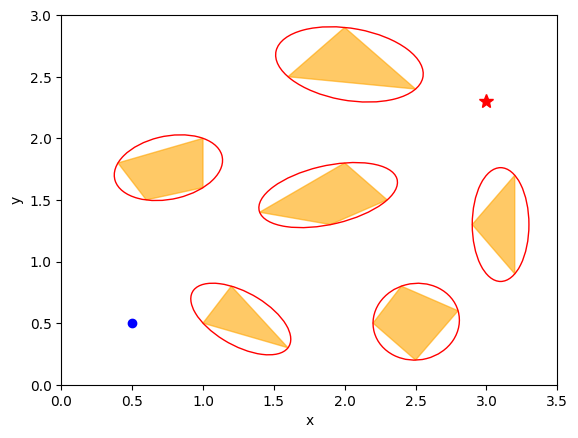

In [4]:
from matplotlib.patches import Ellipse

# Minimum volume enclosing ellipsoid algorithm
def mvee(points, tol=0.0001):
    """
    Finds the ellipse equation in "center form"
    (x-c).T * A * (x-c) = 1
    c is the center of the ellipsoid.
    A is a positive definite matrix that defines the shape and orientation of the ellipsoid.
    """
    N, d = points.shape
    Q = np.column_stack((points, np.ones(N))).T
    err = tol+1.0
    u = np.ones(N)/N
    while err > tol:
        X = np.dot(np.dot(Q, np.diag(u)), Q.T)
        M = np.diag(np.dot(np.dot(Q.T, np.linalg.inv(X)), Q))
        jdx = np.argmax(M)
        step_size = (M[jdx]-d-1.0)/((d+1)*(M[jdx]-1.0))
        new_u = (1-step_size)*u
        new_u[jdx] += step_size
        err = np.linalg.norm(new_u-u)
        u = new_u
    c = np.dot(u, points)
    A = np.linalg.inv(np.dot(np.dot(points.T, np.diag(u)), points)
               - np.multiply.outer(c, c))/d
    return A, c


def generate_ellipses_patches(ellipses: list, color: list[int, int, int] = [0, 0, 1]):
  """
  Generates a list of ellipse patches for the plot
  """
  patches = []
  for (A, c) in ellipses:
    Lambda, R = np.linalg.eig(A)
    width = 2 * sqrt(1 / Lambda[0])
    height = 2 * sqrt(1 / Lambda[1])
    angle = atan2(R[1, 0], R[0, 0]) * 180 / pi
    ellipse = Ellipse(c, width, height, angle=angle, facecolor='none')
    ellipse.set_edgecolor(color)
    patches.append(ellipse)
  return patches


# initialize list of ellipsoids [(A_1, c_1), ...]
obstacle_ellipsoids = []

for obs in obstacles:
    A, c = mvee(np.array(obs))
    obstacle_ellipsoids.append((A, c))


# Visualize environment
fig, ax = plt.subplots()

ax.add_collection(deepcopy(p_col))

ellipse_patches = generate_ellipses_patches(obstacle_ellipsoids, [1, 0, 0])
for patch in ellipse_patches:
    ax.add_artist(copy(patch))

ax.plot([x0[0]], [x0[1]], marker='o', color="b")
ax.plot([x_ref[0]], [x_ref[1]], marker='*', color="r", markersize=10)
ax.set_xlim([0,3.5])
ax.set_ylim([0,3])
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()


### Enlarging the obstacles, so that we can create a second ellipse to increase the safety region.

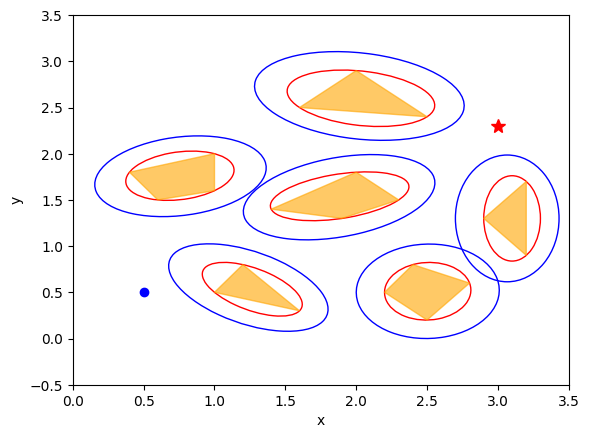

In [5]:
def enlarge_obstacle(obstacle, distance):    
    obstacle = np.array(obstacle) # Convert vertices to a numpy array
    center = np.mean(obstacle, axis=0) # Compute the centroid
    vectors = obstacle - center # Compute vectors from the centroid to the vertices

    norms = np.linalg.norm(vectors, axis=1, keepdims=True) # Normalize the vectors
    unit_vectors = vectors / norms  # Unit directions

    enlarged_obstacle = obstacle + unit_vectors * distance # Add the fixed distance
    
    return enlarged_obstacle.tolist()


# Enlarge each obstacle by a fixed distance
distance = 0.2
enlarged_obstacles = [enlarge_obstacle(obstacle, distance) for obstacle in obstacles]

# Creating the enlarged ellispses
enlarged_ellipses = [tuple(mvee(np.array(obs))) for obs in enlarged_obstacles]

# generate plot objects
enlarged_ellipses_patches = generate_ellipses_patches(enlarged_ellipses)

fig, ax = plt.subplots()

for e_ in enlarged_ellipses_patches:
    ax.add_artist(copy(e_))

for e in ellipse_patches:
    ax.add_artist(copy(e))

ax.add_collection(deepcopy(p_col))
ax.plot([x0[0]], [x0[1]], marker='o', color="b")
ax.plot([x_ref[0]], [x_ref[1]], marker='*', color="r", markersize=10)
ax.set_xlim([0,3.5])
ax.set_ylim([-0.5,3.5])
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

### Formulating the optimization problem and its constraints to get from the initial point to the goal point.

In [6]:
import casadi
import numpy as np
import random 

solver = casadi.Opti()

# Prediction horizon
NPRED = 100

# States
X = solver.variable(3, NPRED)
# Inputs
U = solver.variable(2, NPRED)

# Weight matrices
Q = 10 * np.eye(3)
R = np.diag([2, 2])
P = 10 * Q

XMIN = -1 * 0.2 * np.array([1.0 ,1.0, 1.0])    
XMAX =  1 * 0.2 * np.array([1.0 ,1.0, 1.0]) 

UMIN = -10
UMAX = 10

TE = 0.1

# Nonlinear model dynamics
f_dynamics = casadi.vertcat(U[0] * casadi.cos(X[2]), U[0] * casadi.sin(X[2]), U[1])
f_dynamics_func = casadi.Function('f_dynamics', [X, U], [f_dynamics]) 

# Cost function
J = 0 
for k in range(0, NPRED-1):
  J += casadi.mtimes([(X[:, k] - x_ref).T, Q, (X[:, k] - x_ref)]) + casadi.mtimes([U[:, k].T, R, U[:, k]])
J += casadi.mtimes([(X[:, NPRED - 1] - x_ref).T, P, (X[:, NPRED - 1] - x_ref)])

solver.minimize(J)  # Minimize the total cost

# Dynamics constraints
for k in range(NPRED-1):
  if k % 8 == 0:
    d = np.array([random.uniform(-0.1, 0.1), 0., 0.])
    solver.subject_to(X[:, k+1] == (X[:, k] + TE * f_dynamics_func(X[:, k], U[:, k]) + d))
  else:
    solver.subject_to(X[:, k+1] == (X[:, k] + TE * f_dynamics_func(X[:, k], U[:, k])))
  solver.subject_to(XMIN <= (X[:, k + 1] - X[:, k]))
  solver.subject_to((X[:, k + 1] - X[:, k]) <= XMAX)

# Position constraints
# The position of the obstacles is already known
for obstacle in enlarged_ellipses:
  print(obstacle)
  A_tilde, c_tilde = obstacle
  for k in range(NPRED-1):
    solver.subject_to(casadi.mtimes([(X[0:2, k+1] - c_tilde).T, A_tilde, (X[0:2, k+1] - c_tilde)]) > 1)

# Control input constraints
for k in range(NPRED-1):
  solver.subject_to(U[0, k] >= UMIN)
  solver.subject_to(U[0, k] <= UMAX)

# Initial and final state constraints
solver.subject_to(X[:, 0] == x0)
solver.subject_to(X[:, -1] == x_ref)

solver.solver('ipopt')
sol = solver.solve()

traj = sol.value(X)
traj1 = traj
controls = sol.value(U)

(array([[4.186816 , 2.463302 ],
       [2.463302 , 5.9168717]]), array([1.23896123, 0.55150969]))
(array([[ 2.85599205, -0.82056784],
       [-0.82056784,  5.47476808]]), array([0.76001895, 1.75615385]))
(array([[ 2.47007975, -1.21969245],
       [-1.21969245,  5.29893983]]), array([1.87941733, 1.52935136]))
(array([[7.47855981, 0.        ],
       [0.        , 2.12542948]]), array([3.06567142, 1.3       ]))
(array([[ 3.92983591, -0.0879341 ],
       [-0.0879341 ,  3.83074843]]), array([2.50495285, 0.51119777]))
(array([[1.92101983, 0.65076047],
       [0.65076047, 4.56023213]]), array([2.02228815, 2.625007  ]))

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
*************************************************************************

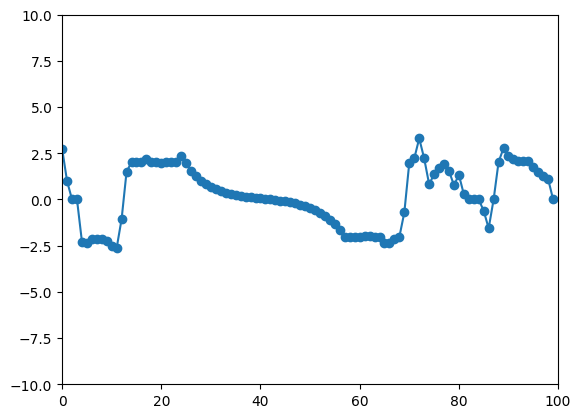

In [7]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(controls[0, :], marker='o')
ax.set_xlim([0,NPRED])
ax.set_ylim([-10,10])
plt.show()

### Plotting the trajectory

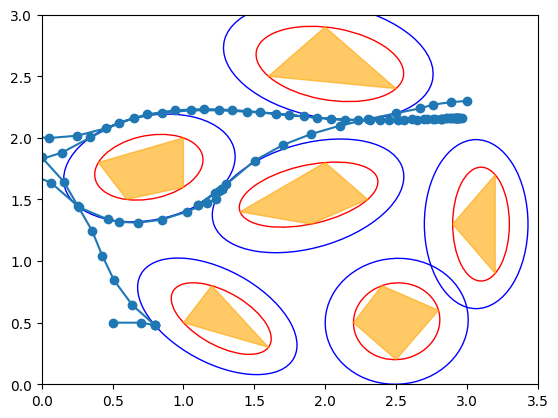

In [8]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(traj[0, :], traj[1, :], marker='o')

for e_ in enlarged_ellipses_patches:
    ax.add_artist(copy(e_))

for e in ellipse_patches:
    ax.add_artist(copy(e))

ax.add_collection(copy(p_col))
ax.set_xlim([0,3.5])
ax.set_ylim([0,3])
plt.show()

ax.set_xlabel("x")
ax.set_ylabel("y")

plt.show()

**The animation!**

In [9]:
%matplotlib inline
%matplotlib notebook
%matplotlib notebook
%matplotlib inline
%matplotlib notebook
%matplotlib notebook
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Circle
from IPython.display import HTML
from math import *

def animation_func(i, data):
    x = data[0]
    y = data[1]
    theta = data[2]
    # TurtleBot dimension
    l = 2 * r_robot
    p1 = [x[i] + cos(theta[i]) * l/2, y[i] + sin(theta[i]) * l/2]
    p2 = [x[i] - cos(theta[i]) * l/2, y[i] - sin(theta[i]) * l/2]
    line1.set_xdata([p1[0], p2[0]])
    line1.set_ydata([p1[1], p2[1]])

    # Update circle position
    robot_circle.center = (x[i], y[i])  # Update the center of the circle

    # Plot trajectory
    pt, = ax.plot([x[i]], [y[i]], "g.", markersize=1)

    ax.add_collection(deepcopy(p_col))

    return line1, pt


fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
ax.set_xlim([0., 4.])
ax.set_ylim([0, 4.])
line1, = ax.plot([x0[0]-0.15, x0[0] + 0.15], [0., 0.], 'ko-', lw=1.5, markersize=5)

# Initialize the circle representing the TurtleBot
robot_circle = Circle((0, 0), r_robot, color='blue', alpha=0.6)  
ax.add_patch(robot_circle)

for e_ in enlarged_ellipses_patches:
    ax.add_artist(copy(e_))

for e in ellipse_patches:
    ax.add_artist(copy(e))

x_data = traj[0, :]
y_data = traj[1, :]
theta_data = traj[2, :]
animation = FuncAnimation(fig, animation_func, fargs=((x_data, y_data, theta_data),),
                          frames=NPRED, interval=50, blit=True)
# plt.show()
HTML(animation.to_html5_video())

<IPython.core.display.Javascript object>

## Optimization-based Motion Planning: Dynamic Obstacles
### Creation of moving obstacles by aplying velocities on each one of them.

In [10]:
%matplotlib inline
%matplotlib notebook
%matplotlib notebook

import math

def find_new_vertex_position(obstacle, velocity, angle, k):
  updated_x = obstacle[k][0] +  TE * cos(angle) * velocity
  updated_y = obstacle[k][1] +  TE * sin(angle) * velocity
  return updated_x, updated_y

def find_new_obstacle_position(obstacle, velocity, angle):
  new_obstacle = []
  for k in range(len(obstacle)):
    updated_obstacle = find_new_vertex_position(obstacle, velocity, angle, k)
    new_obstacle.append(updated_obstacle)
  return new_obstacle

def find_timed_obstacles(obstacles: list, velocity_dirs, velocities, timed_obstacles, k):
  list_new_obstacles = []
  for i in range(len(obstacles)):

    # Get the velocity direction and magnitude for this obstacle
    vel_dir = velocity_dirs[i]
    angle = math.atan2(vel_dir[1], vel_dir[0])
    vel_mag = velocities[i]
    obstacle = timed_obstacles[k-1][i]

    # Update each obstacle
    new_obstacle = find_new_obstacle_position(obstacle, vel_mag, angle )
    list_new_obstacles.append(new_obstacle)
  return list_new_obstacles

# velocity vectors in xy-plane
velocity_dirs = [[1., 0.], [1., 0.4], [0.4, -1.], [-1, 0.5], [-0.1, 1.], [1., 0.2]]

# velocity magnitudes
velocities = [0.1, 0.15, 0.1, 0.4, 0.3, 0.05]

# list of obstacles at each timestep
timed_obstacles = []
timed_obstacles.append(deepcopy(obstacles))

# for the normal obstacles
for k in range(1, NPRED):
  list_new_obstacles = find_timed_obstacles(obstacles, velocity_dirs, velocities, timed_obstacles, k)
  timed_obstacles.append(list_new_obstacles)


def animation_obstacles(i):
    for j, p in enumerate(moving_patches):
        new_pos = np.append(timed_obstacles[i][j], [timed_obstacles[i][j][0]], axis=0)
        p.set_xy(new_pos)

    return moving_patches,


fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
ax.set_xlim([0., 4.])
ax.set_ylim([0., 4.])

moving_patches = []
for p in patches:
    polygon = Polygon(p.get_xy(), facecolor='orange', alpha=0.6)
    moving_patches.append(polygon)

for p in moving_patches:
    ax.add_patch(p)
    
animation = FuncAnimation(fig, animation_obstacles, frames=NPRED, interval=50, blit=True)

HTML(animation.to_html5_video())

<IPython.core.display.Javascript object>

### Creation of moving ellipses for the normal obstacles and the enlarged ones.

In [11]:
%matplotlib inline
%matplotlib notebook
%matplotlib notebook

# list of list of ellipses at each time step for the normal obstacles
timed_ellipses = []

for elements in timed_obstacles:
  list_ellipses = []
  for obs in elements:
    A, c = mvee(np.array(obs))
    list_ellipses.append((A, c))
  timed_ellipses.append(list_ellipses)


# Creation of a list of list of ellipses at each time step for the normal obstacles
timed_enlarged_ellipses = []

# list of obstacles at each timestep
timed_enlarged_obstacles = []
timed_enlarged_obstacles.append(deepcopy(enlarged_obstacles))

# for the enlarged obstacles
for k in range(1, NPRED):
  list_new_obstacles = find_timed_obstacles(enlarged_obstacles, velocity_dirs, velocities, timed_enlarged_obstacles, k)
  timed_enlarged_obstacles.append(list_new_obstacles)

for elements in timed_enlarged_obstacles:
  list_enlarged_ellipses = []
  for obs in elements:
    A, c = mvee(np.array(obs))
    list_enlarged_ellipses.append((A, c))
  timed_enlarged_ellipses.append(list_enlarged_ellipses)



# Animations
def animation_ellipses(i):
    for j, p in enumerate(moving_patches):
        new_pos = np.append(timed_obstacles[i][j], [timed_obstacles[i][j][0]], axis=0)
        p.set_xy(new_pos)

    for j, e in enumerate(moving_enlarged_ellipse_patches):
        e.set_center(timed_enlarged_ellipses[i][j][1])

    for j, e in enumerate(moving_ellipse_patches):
        e.set_center(timed_ellipses[i][j][1])

    return moving_patches, moving_ellipse_patches, moving_enlarged_ellipse_patches


fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
ax.set_xlim([0., 4.])
ax.set_ylim([0., 4.])

moving_patches = []
for p in patches:
    polygon = Polygon(p.get_xy(), facecolor='orange', alpha=0.6)
    moving_patches.append(polygon)

for p in moving_patches:
    ax.add_patch(p)


moving_enlarged_ellipse_patches = []
for e in enlarged_ellipses_patches:
  moving_enlarged_ellipse_patches.append(Ellipse(e.get_center(), e.width, e.height, angle=e.angle, facecolor='none'))

for e in moving_enlarged_ellipse_patches:
    e.set_edgecolor([0, 0, 1])
    ax.add_artist(e)


moving_ellipse_patches = []
for e in ellipse_patches:
  moving_ellipse_patches.append(Ellipse(e.get_center(), e.width, e.height, angle=e.angle, facecolor='none'))

for e in moving_ellipse_patches:
    e.set_edgecolor([1, 0, 0])
    ax.add_artist(e)

animation = FuncAnimation(fig, animation_ellipses, frames=NPRED, interval=50, blit=True)

# plt.show()
HTML(animation.to_html5_video())

<IPython.core.display.Javascript object>

### Computing the optimization problem for the moving obstacles, but this time, the position of each obstacle will be known at each step.

In [12]:
# Initial & Goal states
x0 = [0.5, 0.5, 0.]
x_ref = [3., 2., 0.]
# x_ref = [3., 2.3, 0.]

# States
X = solver.variable(3, NPRED)
# Inputs
U = solver.variable(2,NPRED)

# Weight matrices
Q = 10 * np.eye(3)  
R = np.diag([2, 2])
P = 10 * Q

J = 0  # Initialize the total cost
for k in range(0, NPRED-1):
  J += casadi.mtimes([(X[:, k] - x_ref).T, Q, (X[:, k] - x_ref)]) + casadi.mtimes([U[:, k].T, R, U[:, k]])
J += casadi.mtimes([(X[:, NPRED - 1] - x_ref).T, P, (X[:, NPRED - 1] - x_ref)]) + casadi.mtimes([U[:, k].T, R, U[:, k]])

solver.minimize(J)  # Minimize the total cost

# Dynamics constraints
for k in range(NPRED-1):
  if k % 8 == 0:
    d = np.array([random.uniform(-0.1, 0.1), 0., 0.])
    solver.subject_to(X[:, k+1] == (X[:, k] + TE * f_dynamics_func(X[:, k], U[:, k]) + d))
  else:
    solver.subject_to(X[:, k+1] == (X[:, k] + TE * f_dynamics_func(X[:, k], U[:, k])))
  solver.subject_to(XMIN <= (X[:, k + 1] - X[:, k]))
  solver.subject_to((X[:, k + 1] - X[:, k]) <= XMAX)


# Position constraints
# Obstacles are changing position at each moment with a constant velocity
for k in range(NPRED - 1):
  for obstacle in timed_enlarged_ellipses[k + 1]:
    A_tilde, c_tilde = obstacle
    solver.subject_to(casadi.mtimes([(X[0:2, k + 1] - c_tilde).T, A_tilde, (X[0:2, k + 1] - c_tilde)]) > 1)


# Input constraints
for k in range(NPRED-1):
  solver.subject_to(U[0, k] >= UMIN)
  solver.subject_to(U[0, k] <= UMAX)

# Initial and final state constraints
solver.subject_to(X[:, 0] == x0)
solver.subject_to(X[:, -1] == x_ref)

solver.solver('ipopt')
sol = solver.solve()

traj = sol.value(X)
controls = sol.value(U)

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     2190
Number of nonzeros in inequality constraint Jacobian.:     5148
Number of nonzeros in Lagrangian Hessian.............:     1491

Total number of variables............................:     1000
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      606
Total number of inequality constraints...............:     2772
        inequality constraints with only lower bounds:     1980
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      792

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.4170000e+04 3.00e+00 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

### Animation of the results!

In [13]:
%matplotlib inline
%matplotlib notebook
%matplotlib notebook
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from math import *

def animation_func(i, data):
    x = data[0]
    y = data[1]
    theta = data[2]
    # TurtleBot dimension
    l = 2 * r_robot
    p1 = [x[i] + cos(theta[i]) * l/2, y[i] + sin(theta[i]) * l/2]
    p2 = [x[i] - cos(theta[i]) * l/2, y[i] - sin(theta[i]) * l/2]
    line1.set_xdata([p1[0], p2[0]])
    line1.set_ydata([p1[1], p2[1]])
    # Plot trajectory
    pt, = ax.plot([x[i]], [y[i]], "g.", markersize=1)

    # Update circle position
    robot_circle.center = (x[i], y[i])  # Update the center of the circle

    for j, p in enumerate(moving_patches):
        new_pos = np.append(timed_obstacles[i][j], [timed_obstacles[i][j][0]], axis=0)
        p.set_xy(new_pos)

    for j, e in enumerate(moving_enlarged_ellipse_patches):
        e.set_center(timed_enlarged_ellipses[i][j][1])

    for j, e in enumerate(moving_ellipse_patches):
        e.set_center(timed_ellipses[i][j][1])

    return line1, pt, moving_patches, moving_ellipse_patches, moving_enlarged_ellipse_patches

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
ax.set_xlim([0., 4.])
ax.set_ylim([0., 4.])
line1, = ax.plot([x0[0]-0.15, x0[0] + 0.15], [0., 0.], 'ko-', lw=1.5, markersize=5)


moving_patches = []
for p in patches:
    polygon = Polygon(p.get_xy(), facecolor='orange', alpha=0.6)
    moving_patches.append(polygon)

for p in moving_patches:
    ax.add_patch(p)

moving_enlarged_ellipse_patches = []
for e in enlarged_ellipses_patches:
  moving_enlarged_ellipse_patches.append(Ellipse(e.get_center(), e.width, e.height, angle=e.angle, facecolor='none'))

for e in moving_enlarged_ellipse_patches:
    e.set_edgecolor([0, 0, 1])
    ax.add_artist(e)

moving_ellipse_patches = []
for e in ellipse_patches:
  moving_ellipse_patches.append(Ellipse(e.get_center(), e.width, e.height, angle=e.angle, facecolor='none'))

for e in moving_ellipse_patches:
    e.set_edgecolor([1, 0, 0])
    ax.add_artist(e)

# Initialize the circle representing the TurtleBot
robot_circle = Circle((0, 0), r_robot, color='blue', alpha=0.6)  
ax.add_patch(robot_circle)

x_data = traj[0, :]
y_data = traj[1, :]
theta_data = traj[2, :]
animation = FuncAnimation(fig, animation_func, fargs=((x_data, y_data, theta_data),),
                          frames=NPRED-1, interval=50, blit=True)

HTML(animation.to_html5_video())

<IPython.core.display.Javascript object>